In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.init as init

torch.manual_seed(24)

MASS = 1.0
HBAR = 1.0
AUTOEV = 27.2114
AUTONM = 0.05291772108

# qGrid: 0.0 to 5.0; NGRID = 1024; 
# rGrid: 0.0 to 0.02*TWOPI / (NGRID * dq)    --> 0.0 to 25.7108; NGRID = 1024; 
NQGRID = 2048
qGrid = torch.linspace(0.0, 10.0, NQGRID, dtype=torch.float64)
dq = (10.0-0.0)/NQGRID

In [2]:
def plotBandStruct(bandStruct_array, marker_array, label_array): 
    fig, axs = plt.subplots(1,1, figsize=(3,3))
    for bandStructIndex in range(len(bandStruct_array)): 
        numBands = len(bandStruct_array[bandStructIndex][0])
        numKpts = len(bandStruct_array[bandStructIndex])
        for i in range(numBands): 
            if i==0: 
                axs.plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i].detach().numpy(), marker_array[bandStructIndex], label=label_array[bandStructIndex])
            else: 
                axs.plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i].detach().numpy(), marker_array[bandStructIndex])
    axs.legend(frameon=False)
    plt.show()
    return

def pot_func(x, params): 
    pot = (params[0]*(x*x - params[1]) / (params[2] * np.exp(params[3]*x*x) - 1.0))
    return pot
    
def plotPP(q_array, vq_Cd_array, vq_Se_array, label_array, lineshape_array): 
    fig, axs = plt.subplots(1,1, figsize=(3,3))
    for i in range(len(vq_Cd_array)): 
        q = q_array[i].detach().numpy()
        vq_Cd = vq_Cd_array[i].detach().numpy()
        vq_Se = vq_Se_array[i].detach().numpy()
        axs.plot(q, vq_Cd, lineshape_array[i], label="Cd "+label_array[i])
        axs.plot(q, vq_Se, lineshape_array[i], label="Se "+label_array[i])
    axs.set(xlabel=r"$q$", ylabel=r"$v(q)$")
    axs.legend(frameon=False)
    plt.show()
    return

In [3]:
# Semiconductor system details

nSystem = 1

# read system
scale = 11.4485278
unitCellVector1 = torch.tensor([0.0, 0.5, 0.5], dtype=torch.float64) * scale
unitCellVector2 = torch.tensor([0.5, 0.0, 0.5], dtype=torch.float64) * scale
unitCellVector3 = torch.tensor([0.5, 0.5, 0.0], dtype=torch.float64) * scale
unitCellVectors = torch.cat((unitCellVector1.unsqueeze(0), unitCellVector2.unsqueeze(0), unitCellVector3.unsqueeze(0)), dim=0)
cellVolume = torch.dot(unitCellVector1, torch.cross(unitCellVector2, unitCellVector3))

# calculate reciprocal space vectors
prefactor = 2 * np.pi / cellVolume
gVector1 = prefactor * torch.cross(unitCellVectors[1], unitCellVectors[2])
gVector2 = prefactor * torch.cross(unitCellVectors[2], unitCellVectors[0])
gVector3 = prefactor * torch.cross(unitCellVectors[0], unitCellVectors[1])
gVectors = torch.cat((gVector1.unsqueeze(0), gVector2.unsqueeze(0), gVector3.unsqueeze(0)), dim=0)

nAtoms = 2
atomTypes = np.array(["Cd", "Se"])
atomPos = torch.tensor([[0.125, 0.125, 0.125],
                        [-0.125, -0.125, -0.125]], dtype=torch.float64)
atomPos = atomPos @ unitCellVectors
# print(atomPos)

# read kPoints
kpt_zbCdSe = torch.tensor(np.loadtxt("ZB_kpoints.par"))
kpt_zbCdSe = kpt_zbCdSe @ gVectors
nkpt = kpt_zbCdSe.shape[0]
# Gamma = torch.tensor([0.0, 0.0, 0.0], dtype=torch.float64)

# read band strcture
Eref_zbCdSe = torch.tensor(np.loadtxt("bandStruct_zbCdSe.par")[:, 1:])

maxKE = 10

nBands = 16

In [4]:
# Current Cd, Se, S pp's in Zunger's form
CdParams = torch.tensor([-31.4518, 1.3890, -0.0502, 1.6603, 0.0586], dtype=torch.float64)
SeParams = torch.tensor([8.4921, 4.3513, 1.3600, 0.3227, 0.1746], dtype=torch.float64)
SParams = torch.tensor([7.6697, 4.5192, 1.3456, 0.3035, 0.2087], dtype=torch.float64)
PP_order = np.array(["Cd", "Se", "S"])
totalParams = torch.cat((CdParams.unsqueeze(0), SeParams.unsqueeze(0), SParams.unsqueeze(0)), dim=0)

CdPP = pot_func(qGrid, CdParams)
SePP = pot_func(qGrid, SeParams)
# totalPP = torch.cat((CdPP.unsqueeze(0), SePP.unsqueeze(0)), dim=0)

In [26]:
def basis(maxKE, scale, unitCellVectors, gVectors, cellVolume): 
    minGMag = min(torch.norm(gVectors[0]), torch.norm(gVectors[1]), torch.norm(gVectors[2]))
    numMaxBasisVectors = int(np.sqrt(2*maxKE) / minGMag)
    # print(numMaxBasisVectors)

    k = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float64).repeat((2*numMaxBasisVectors+1)**2)
    j = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float64).repeat_interleave((2*numMaxBasisVectors+1)).repeat((2*numMaxBasisVectors+1))
    i = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float64).repeat_interleave((2*numMaxBasisVectors+1)**2)
    allGrid = torch.vstack((i, j, k)).T
    transform = gVectors.T
    allBasisSet = allGrid @ transform
    # print(allBasisSet.shape[0])
    # print(allBasisSet)

    row_norms = torch.norm(allBasisSet, dim=1)
    condition = (HBAR*0.5*row_norms**2 / MASS < maxKE)
    indices = torch.where(condition)[0]
    basisSet = allBasisSet[indices]
    # print(basisSet.shape[0])
    # print(basisSet)
    
    sorting_indices = torch.argsort(basisSet[:, 2], stable=True)
    basisSet = basisSet[sorting_indices]
    sorting_indices = torch.argsort(basisSet[:, 1], stable=True)
    basisSet = basisSet[sorting_indices]
    sorting_indices = torch.argsort(basisSet[:, 0], stable=True)
    basisSet = basisSet[sorting_indices]
    row_norms = torch.norm(basisSet, dim=1)
    sorting_indices = torch.argsort(row_norms[:], stable=True)
    sorted_basisSet = basisSet[sorting_indices]
    
    return sorted_basisSet

# construct hamiltonian at a certain k-point (kVector). Quicker through vectorization. 
def calcHamiltonianMatrix(NN_boolean, basisStates, kVector, nAtoms, cellVolume):
    n = basisStates.shape[0]
    HMatrix = torch.zeros((n, n), dtype=torch.complex128)

    # Kinetic energy
    for i in range(n): 
        HMatrix[i,i] += HBAR**2 / (2*MASS) * (torch.norm(basisStates[i] + kVector))**2
        
    # Local potential
    gDiff = torch.stack([basisStates] * (basisStates.shape[0]), dim=1) - basisStates.repeat(basisStates.shape[0], 1, 1)
    
    for k in range(nAtoms): 
        gDiffDotTau = torch.sum(gDiff * atomPos[k], axis=2)
        structFact = 1/cellVolume * (torch.cos(gDiffDotTau) + 1j*torch.sin(gDiffDotTau))

        thisAtomIndex = np.where(atomTypes[k]==PP_order)[0]
        if len(thisAtomIndex)!=1: 
            raise ValueError("Type of atoms in PP. ")
        thisAtomIndex = thisAtomIndex[0]
        
        if NN_boolean: 
            atomFF = PPmodel(torch.norm(gDiff, dim=2).view(-1, 1))
            atomFF = atomFF[:, thisAtomIndex].view(n, n)
        else: 
            atomFF = pot_func(torch.norm(gDiff, dim=2), totalParams[thisAtomIndex])
        
        HMatrix += atomFF * structFact
    return HMatrix

def calcBandStruct(NN_boolean, basisStates, nkpt, kpts_coord, nAtoms, cellVolume, nBands): 
    bandStruct = torch.zeros((nkpt, nBands), dtype=torch.float64)
    for kpt_index in range(nkpt): 
        HamiltonianMatrixAtKpt = calcHamiltonianMatrix(NN_boolean, basisStates, kpts_coord[kpt_index], nAtoms, cellVolume)

        # diagonalize the hamiltonian
        energies = torch.linalg.eigvalsh(HamiltonianMatrixAtKpt)
        
        energiesEV = energies * AUTOEV
        # 2-fold degeneracy due to spin
        final_energies = energiesEV.repeat_interleave(2)[:nBands]
    
        bandStruct[kpt_index] = final_energies

    return bandStruct

tensor([[ 0.7157,  0.1118],
        [-0.0647, -0.3685]], dtype=torch.float64, grad_fn=<AddmmBackward0>)


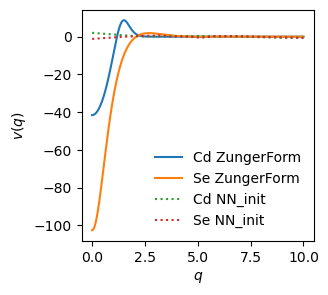

In [27]:
# Create Net model class
'''
class Net(nn.Module):
    # Constructor
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        self.batch_norm = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            layer = nn.Linear(input_size, output_size, dtype=torch.float64)
            init.xavier_normal_(layer.weight)
            init.constant_(layer.bias, 0)
            self.hidden.append(layer)
            if output_size != Layers[-1]:
                self.batch_norm.append(nn.BatchNorm1d(output_size, dtype=torch.float64))
    # Prediction
    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in enumerate(self.hidden):
            if l < L - 1:
                activation = torch.relu(linear_transform(activation))
                activation = self.batch_norm[l](activation)
            else:
                activation = linear_transform(activation)
        return activation

Layers = [1, 20, 2]
PPmodel = Net(Layers)
'''

# Added batch normalization, xavier initialization
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.input_layer = nn.Linear(1, 20, dtype=torch.float64) 
        self.bn1 = nn.BatchNorm1d(20, dtype=torch.float64) 

        self.hidden_layer1 = nn.Linear(20, 20, dtype=torch.float64) 
        self.bn2 = nn.BatchNorm1d(20, dtype=torch.float64)  

        self.hidden_layer2 = nn.Linear(20, 20, dtype=torch.float64) 
        self.bn3 = nn.BatchNorm1d(20, dtype=torch.float64) 

        self.output_layer = nn.Linear(20, 2, dtype=torch.float64) 

        # Xavier initialization for weights
        init.xavier_normal_(self.input_layer.weight)
        init.xavier_normal_(self.hidden_layer1.weight)
        init.xavier_normal_(self.hidden_layer2.weight)
        init.xavier_normal_(self.output_layer.weight)

    def forward(self, x):
        x = torch.relu(self.bn1(self.input_layer(x)))  
        x = torch.relu(self.bn2(self.hidden_layer1(x)))
        x = torch.relu(self.bn3(self.hidden_layer2(x)))
        x = self.output_layer(x)
        return x

PPmodel = Net()


# print("list(model.parameters()):\n ", list(PPmodel.parameters()))
# print("\nmodel.state_dict():\n ", PPmodel.state_dict())
print(PPmodel(torch.tensor([[1.0], [2.0]], dtype=torch.float64)))
# print(PPmodel(torch.tensor([[1.0]], dtype=torch.float64)))

# Validating on the initialized NN model
NN_init = PPmodel(qGrid.view(-1, 1))
plotPP([qGrid, qGrid], [CdPP, NN_init[:, 0]], [SePP, NN_init[:, 1]], ["ZungerForm", "NN_init"], ["-", ":"])

Epoch [100/1000], Loss: 1.9204


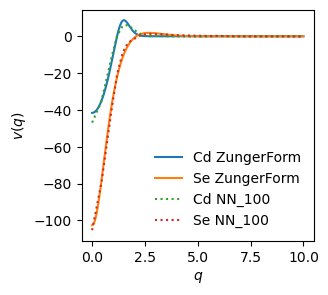

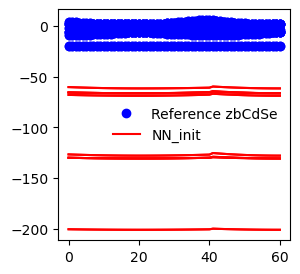

Epoch [200/1000], Loss: 0.4006


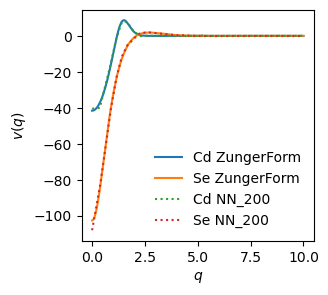

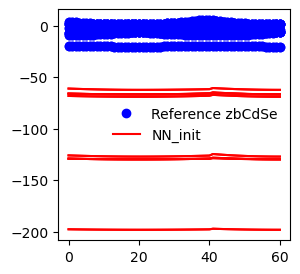

Epoch [300/1000], Loss: 0.3382


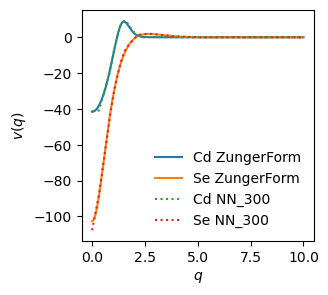

KeyboardInterrupt: 

In [20]:
# Initialize the NN parameters to fit the current Zunger form
def totalMSELoss(output, target):
    loss = torch.mean((output - target) ** 2)
    return loss

optimizer = torch.optim.Adam(PPmodel.parameters(), lr=0.1)
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    inputs = qGrid.reshape(-1, 1)
    CdOutputs = PPmodel(inputs)[:,0]
    SeOutputs = PPmodel(inputs)[:,1]
    
    CdTargets = torch.zeros_like(CdOutputs)
    SeTargets = torch.zeros_like(CdOutputs)
    for i, x in enumerate(qGrid):
        CdTargets[i] = pot_func(x, CdParams)
        SeTargets[i] = pot_func(x, SeParams)
    
    loss = totalMSELoss(CdOutputs, CdTargets) + totalMSELoss(SeOutputs, SeTargets)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
        NN_init = PPmodel(qGrid.view(-1, 1))
        plotPP([qGrid, qGrid], [CdPP, NN_init[:, 0]], [SePP, NN_init[:, 1]], ["ZungerForm", f"NN_{epoch+1}"], ["-", ":"]);

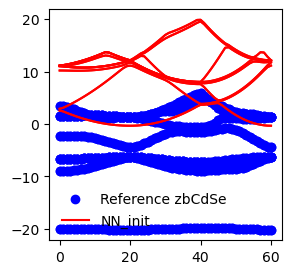

In [25]:
basisStates = basis(maxKE, scale, unitCellVectors, gVectors, cellVolume)

NN_init_BandStruct = calcBandStruct(True, basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)
plotBandStruct([Eref_zbCdSe, NN_init_BandStruct], ["bo", "r-"], ["Reference zbCdSe", "NN_init"])

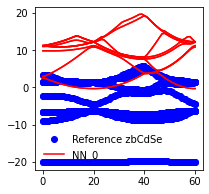

Loss: 222.48391681858178
Parameter: input_layer.weight, Gradient Norm: 0.4064261942045223
Parameter: input_layer.bias, Gradient Norm: 1.5017110250403142e-12
Parameter: bn1.weight, Gradient Norm: 25.98522435460726
Parameter: bn1.bias, Gradient Norm: 13.837750000549658
Parameter: hidden_layer1.weight, Gradient Norm: 134.10073444449202
Parameter: hidden_layer1.bias, Gradient Norm: 1.8734958124332418e-13
Parameter: bn2.weight, Gradient Norm: 17.50049506586409
Parameter: bn2.bias, Gradient Norm: 8.128311398011148
Parameter: hidden_layer2.weight, Gradient Norm: 79.35156125566641
Parameter: hidden_layer2.bias, Gradient Norm: 8.27715559840182e-14
Parameter: bn3.weight, Gradient Norm: 12.72854024756883
Parameter: bn3.bias, Gradient Norm: 11.990045677265282
Parameter: output_layer.weight, Gradient Norm: 41.12342758536848
Parameter: output_layer.bias, Gradient Norm: 9.356521109238587


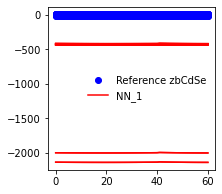

Loss: 1199239.292280713
Parameter: input_layer.weight, Gradient Norm: 0.07219601099146333
Parameter: input_layer.bias, Gradient Norm: 2.2179520911825084e-10
Parameter: bn1.weight, Gradient Norm: 68858.94826049932
Parameter: bn1.bias, Gradient Norm: 27006.971923462144
Parameter: hidden_layer1.weight, Gradient Norm: 53161.00448301286
Parameter: hidden_layer1.bias, Gradient Norm: 2.8492549783699267e-11
Parameter: bn2.weight, Gradient Norm: 34345.75782295537
Parameter: bn2.bias, Gradient Norm: 25142.189949305466
Parameter: hidden_layer2.weight, Gradient Norm: 29299.83212025717
Parameter: hidden_layer2.bias, Gradient Norm: 9.464222971175284e-11
Parameter: bn3.weight, Gradient Norm: 102151.43068118287
Parameter: bn3.bias, Gradient Norm: 222159.2455736843
Parameter: output_layer.weight, Gradient Norm: 223084.7710197741
Parameter: output_layer.bias, Gradient Norm: 23793.713670962738


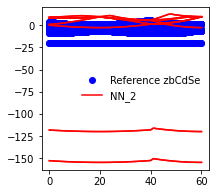

Loss: 3829.8770360983335
Parameter: input_layer.weight, Gradient Norm: 0.0011323091066208258
Parameter: input_layer.bias, Gradient Norm: 4.972063059169344e-13
Parameter: bn1.weight, Gradient Norm: 96.01347269154162
Parameter: bn1.bias, Gradient Norm: 150.26267084785525
Parameter: hidden_layer1.weight, Gradient Norm: 61.87047429234128
Parameter: hidden_layer1.bias, Gradient Norm: 3.900863574719056e-14
Parameter: bn2.weight, Gradient Norm: 189.11594216448827
Parameter: bn2.bias, Gradient Norm: 144.13439041024657
Parameter: hidden_layer2.weight, Gradient Norm: 84.88749680634051
Parameter: hidden_layer2.bias, Gradient Norm: 2.077301318323821e-13
Parameter: bn3.weight, Gradient Norm: 2131.979961152246
Parameter: bn3.bias, Gradient Norm: 3125.6415229257727
Parameter: output_layer.weight, Gradient Norm: 4427.167963504132
Parameter: output_layer.bias, Gradient Norm: 1415.807360699239


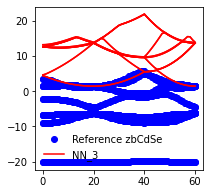

Loss: 278.245167015747
Parameter: input_layer.weight, Gradient Norm: 0.003684357667456896
Parameter: input_layer.bias, Gradient Norm: 6.350598987221332e-14
Parameter: bn1.weight, Gradient Norm: 11.703965410104468
Parameter: bn1.bias, Gradient Norm: 2.8089176170424333
Parameter: hidden_layer1.weight, Gradient Norm: 5.367739001344921
Parameter: hidden_layer1.bias, Gradient Norm: 1.1469696505213665e-15
Parameter: bn2.weight, Gradient Norm: 7.709152651383554
Parameter: bn2.bias, Gradient Norm: 4.37355418142504
Parameter: hidden_layer2.weight, Gradient Norm: 8.312956955987966
Parameter: hidden_layer2.bias, Gradient Norm: 6.7783983755856915e-15
Parameter: bn3.weight, Gradient Norm: 35.685394118387066
Parameter: bn3.bias, Gradient Norm: 8.387249005245282
Parameter: output_layer.weight, Gradient Norm: 19.786658041858495
Parameter: output_layer.bias, Gradient Norm: 1.4934244927629066


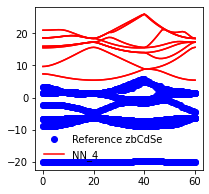

Loss: 431.4660619908019
Parameter: input_layer.weight, Gradient Norm: 8.218301406520908e-06
Parameter: input_layer.bias, Gradient Norm: 1.1149162451956223e-13
Parameter: bn1.weight, Gradient Norm: 21.035284318100675
Parameter: bn1.bias, Gradient Norm: 4.5629684274669815
Parameter: hidden_layer1.weight, Gradient Norm: 10.279263883015046
Parameter: hidden_layer1.bias, Gradient Norm: 1.6845729222092907e-15
Parameter: bn2.weight, Gradient Norm: 8.16341283820844
Parameter: bn2.bias, Gradient Norm: 7.330288277876991
Parameter: hidden_layer2.weight, Gradient Norm: 9.787510055957018
Parameter: hidden_layer2.bias, Gradient Norm: 3.080735923567444e-15
Parameter: bn3.weight, Gradient Norm: 66.80273728640594
Parameter: bn3.bias, Gradient Norm: 14.803597889567794
Parameter: output_layer.weight, Gradient Norm: 36.8810735336564
Parameter: output_layer.bias, Gradient Norm: 0.5156396924221617


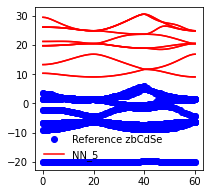

Loss: 645.0840389987751
Parameter: input_layer.weight, Gradient Norm: 9.1836269174561e-06
Parameter: input_layer.bias, Gradient Norm: 1.7561186481108499e-13
Parameter: bn1.weight, Gradient Norm: 32.70627422443514
Parameter: bn1.bias, Gradient Norm: 29.890383378236876
Parameter: hidden_layer1.weight, Gradient Norm: 25.62839384726569
Parameter: hidden_layer1.bias, Gradient Norm: 1.942975788182603e-14
Parameter: bn2.weight, Gradient Norm: 38.65005971039453
Parameter: bn2.bias, Gradient Norm: 18.20943735116685
Parameter: hidden_layer2.weight, Gradient Norm: 44.925148598041446
Parameter: hidden_layer2.bias, Gradient Norm: 4.4108020866960535e-15
Parameter: bn3.weight, Gradient Norm: 52.40099923654448
Parameter: bn3.bias, Gradient Norm: 31.619248172381273
Parameter: output_layer.weight, Gradient Norm: 36.569724045349275
Parameter: output_layer.bias, Gradient Norm: 0.024839756358836677


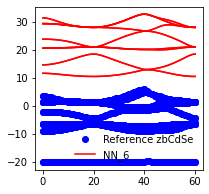

Loss: 744.2030726340711
Parameter: input_layer.weight, Gradient Norm: 6.306160627522365e-06
Parameter: input_layer.bias, Gradient Norm: 1.283787988185944e-13
Parameter: bn1.weight, Gradient Norm: 23.33446280257449
Parameter: bn1.bias, Gradient Norm: 24.895068567436343
Parameter: hidden_layer1.weight, Gradient Norm: 25.691794600032395
Parameter: hidden_layer1.bias, Gradient Norm: 1.1510451432726626e-15
Parameter: bn2.weight, Gradient Norm: 43.558796553872675
Parameter: bn2.bias, Gradient Norm: 32.51171174755825
Parameter: hidden_layer2.weight, Gradient Norm: 7.715770998490529
Parameter: hidden_layer2.bias, Gradient Norm: 2.8437254597355208e-15
Parameter: bn3.weight, Gradient Norm: 41.42961011180452
Parameter: bn3.bias, Gradient Norm: 24.659250353471098
Parameter: output_layer.weight, Gradient Norm: 31.79470457249582
Parameter: output_layer.bias, Gradient Norm: 0.0004842690131321557


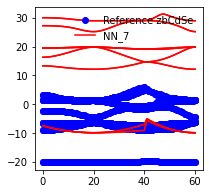

Loss: 412.3162403649732
Parameter: input_layer.weight, Gradient Norm: 2.6929553023705036e-05
Parameter: input_layer.bias, Gradient Norm: 1.1139171052473912e-12
Parameter: bn1.weight, Gradient Norm: 224.40297109199454
Parameter: bn1.bias, Gradient Norm: 78.8078917302687
Parameter: hidden_layer1.weight, Gradient Norm: 133.57087388960485
Parameter: hidden_layer1.bias, Gradient Norm: 3.805659328800593e-14
Parameter: bn2.weight, Gradient Norm: 103.4632644048369
Parameter: bn2.bias, Gradient Norm: 39.869054104843855
Parameter: hidden_layer2.weight, Gradient Norm: 69.5594617276062
Parameter: hidden_layer2.bias, Gradient Norm: 7.572014114298844e-15
Parameter: bn3.weight, Gradient Norm: 172.98277665064006
Parameter: bn3.bias, Gradient Norm: 78.65569502464405
Parameter: output_layer.weight, Gradient Norm: 36.94291369174638
Parameter: output_layer.bias, Gradient Norm: 0.0031422644440611785


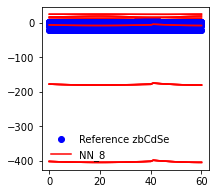

Loss: 45383.87876352792
Parameter: input_layer.weight, Gradient Norm: 0.0041094536315186385
Parameter: input_layer.bias, Gradient Norm: 2.2013287631879866e-10
Parameter: bn1.weight, Gradient Norm: 37963.59025546621
Parameter: bn1.bias, Gradient Norm: 16315.58921510246
Parameter: hidden_layer1.weight, Gradient Norm: 24697.917392677573
Parameter: hidden_layer1.bias, Gradient Norm: 5.292729720533757e-12
Parameter: bn2.weight, Gradient Norm: 17584.069659210367
Parameter: bn2.bias, Gradient Norm: 6838.036422254215
Parameter: hidden_layer2.weight, Gradient Norm: 7982.081837025138
Parameter: hidden_layer2.bias, Gradient Norm: 3.4284332800403068e-12
Parameter: bn3.weight, Gradient Norm: 24430.596085705776
Parameter: bn3.bias, Gradient Norm: 7195.074519775165
Parameter: output_layer.weight, Gradient Norm: 10262.568841374368
Parameter: output_layer.bias, Gradient Norm: 0.08182891159970805


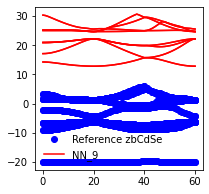

Loss: 744.2193353758374


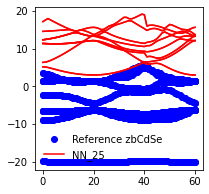

Loss: 280.1385293305477
Parameter: input_layer.weight, Gradient Norm: 1.792236989423733e-05
Parameter: input_layer.bias, Gradient Norm: 1.8019885026405078e-13
Parameter: bn1.weight, Gradient Norm: 35.33249236434861
Parameter: bn1.bias, Gradient Norm: 19.638902627041055
Parameter: hidden_layer1.weight, Gradient Norm: 22.97561016945704
Parameter: hidden_layer1.bias, Gradient Norm: 1.0646807815297764e-14
Parameter: bn2.weight, Gradient Norm: 50.63985802918068
Parameter: bn2.bias, Gradient Norm: 22.546252979972117
Parameter: hidden_layer2.weight, Gradient Norm: 49.78547127760651
Parameter: hidden_layer2.bias, Gradient Norm: 1.7361821889183664e-13
Parameter: bn3.weight, Gradient Norm: 172.11864065903333
Parameter: bn3.bias, Gradient Norm: 77.88327408166977
Parameter: output_layer.weight, Gradient Norm: 49.836787569286635
Parameter: output_layer.bias, Gradient Norm: 8.043486419099029e-05


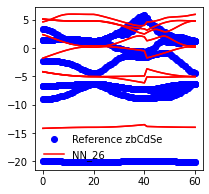

Loss: 16.77670992705851
Parameter: input_layer.weight, Gradient Norm: 7.818273770619992e-05
Parameter: input_layer.bias, Gradient Norm: 1.173869264625714e-12
Parameter: bn1.weight, Gradient Norm: 76.93173266599246
Parameter: bn1.bias, Gradient Norm: 58.135416521034436
Parameter: hidden_layer1.weight, Gradient Norm: 74.94312905884728
Parameter: hidden_layer1.bias, Gradient Norm: 8.513600203577989e-15
Parameter: bn2.weight, Gradient Norm: 185.92478004046012
Parameter: bn2.bias, Gradient Norm: 69.34903819633989
Parameter: hidden_layer2.weight, Gradient Norm: 201.08924901560226
Parameter: hidden_layer2.bias, Gradient Norm: 7.790053771121013e-13
Parameter: bn3.weight, Gradient Norm: 252.39109148845526
Parameter: bn3.bias, Gradient Norm: 161.42371995081365
Parameter: output_layer.weight, Gradient Norm: 48.32657626630622
Parameter: output_layer.bias, Gradient Norm: 0.039811210624496614


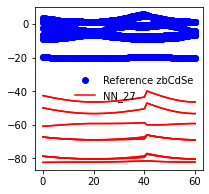

Loss: 3902.980075634931
Parameter: input_layer.weight, Gradient Norm: 0.0003138092633096462
Parameter: input_layer.bias, Gradient Norm: 1.2356518588590068e-11
Parameter: bn1.weight, Gradient Norm: 1925.1822894608051
Parameter: bn1.bias, Gradient Norm: 2417.906008962394
Parameter: hidden_layer1.weight, Gradient Norm: 2284.7971762795028
Parameter: hidden_layer1.bias, Gradient Norm: 1.2318014073590425e-12
Parameter: bn2.weight, Gradient Norm: 6256.969998605543
Parameter: bn2.bias, Gradient Norm: 3614.4764784277804
Parameter: hidden_layer2.weight, Gradient Norm: 5179.383012912628
Parameter: hidden_layer2.bias, Gradient Norm: 1.9370186330608285e-11
Parameter: bn3.weight, Gradient Norm: 9905.454169510109
Parameter: bn3.bias, Gradient Norm: 6195.971469881693
Parameter: output_layer.weight, Gradient Norm: 1691.8304388997071
Parameter: output_layer.bias, Gradient Norm: 1.499147007324465


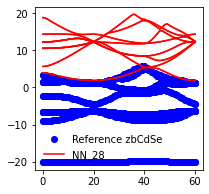

Loss: 263.0517117660211
Parameter: input_layer.weight, Gradient Norm: 2.589156597837048e-06
Parameter: input_layer.bias, Gradient Norm: 1.479094761290564e-13
Parameter: bn1.weight, Gradient Norm: 34.94065171846092
Parameter: bn1.bias, Gradient Norm: 12.74954963152455
Parameter: hidden_layer1.weight, Gradient Norm: 3.5203418223926133
Parameter: hidden_layer1.bias, Gradient Norm: 1.3936905713581904e-15
Parameter: bn2.weight, Gradient Norm: 11.061384764282264
Parameter: bn2.bias, Gradient Norm: 3.254106523418511
Parameter: hidden_layer2.weight, Gradient Norm: 10.074965679883467
Parameter: hidden_layer2.bias, Gradient Norm: 3.3810575201950236e-15
Parameter: bn3.weight, Gradient Norm: 161.08882719460078
Parameter: bn3.bias, Gradient Norm: 59.90722575433096
Parameter: output_layer.weight, Gradient Norm: 47.476939447454896
Parameter: output_layer.bias, Gradient Norm: 0.000251968513435169


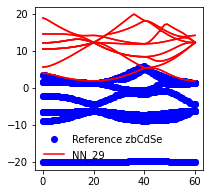

Loss: 261.37136361537995
Parameter: input_layer.weight, Gradient Norm: 4.046778866851379e-06
Parameter: input_layer.bias, Gradient Norm: 2.0640164289438515e-13
Parameter: bn1.weight, Gradient Norm: 53.749530844618235
Parameter: bn1.bias, Gradient Norm: 20.363593742625998
Parameter: hidden_layer1.weight, Gradient Norm: 3.4564119756208806
Parameter: hidden_layer1.bias, Gradient Norm: 2.2111538806223846e-15
Parameter: bn2.weight, Gradient Norm: 11.224360446020942
Parameter: bn2.bias, Gradient Norm: 3.3012265737858035
Parameter: hidden_layer2.weight, Gradient Norm: 12.220126827204211
Parameter: hidden_layer2.bias, Gradient Norm: 1.8486869181358663e-15
Parameter: bn3.weight, Gradient Norm: 163.26507958350552
Parameter: bn3.bias, Gradient Norm: 51.5120497067871
Parameter: output_layer.weight, Gradient Norm: 48.35522832710987
Parameter: output_layer.bias, Gradient Norm: 0.0001379427072829584


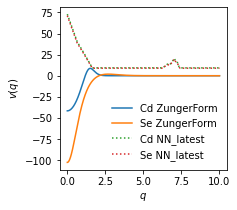

In [12]:
learning_rate = 2
optimizer = torch.optim.Adam(PPmodel.parameters(), lr = learning_rate)

basisStates = basis(maxKE, scale, unitCellVectors, cellVolume)

# torch.autograd.set_detect_anomaly(False)

def train_model(epochs):
    for epoch in range(epochs):
        # for name, param in PPmodel.named_parameters():
        #     print(f"Parameter: {name}, Size: {param.size()}")
        #     print(param.data)
        NN_BandStruct = calcBandStruct(basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)
        plotBandStruct([Eref_zbCdSe, NN_BandStruct], ["bo", "r-"], ["Reference zbCdSe", "NN_"+str(epoch)])
        loss = ((Eref_zbCdSe - NN_BandStruct) ** 2).mean()
        print(f"Loss: {loss}")
        optimizer.zero_grad()
        loss.backward()
        for name, param in PPmodel.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient Norm: {param.grad.norm().item()}")
        optimizer.step()

train_model(30)

NN_latest = PPmodel(qGrid.view(-1, 1))
plotPP([qGrid, qGrid], [CdPP, NN_latest[:, 0]], [SePP, NN_latest[:, 1]], ["ZungerForm", "NN_latest"], ["-", ":"])

In [ ]:
train_model(50)

NN_latest = PPmodel(qGrid.view(-1, 1))
plotPP([qGrid, qGrid], [CdPP, NN_latest[:, 0]], [SePP, NN_latest[:, 1]], ["ZungerForm", "NN_latest"], ["-", ":"])